<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h1 align="center"><font color='#DAA520'>💡 Dental Radiography Image Segmentation</font></h1>

This notebbok contains the code and steps for preprocessing, segmenting, and post-processing dental radiography images to create a dataset of segmented teeth.

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Introduction</h1>  
     
</div>

This project involves the segmentation of dental radiography images to extract individual teeth. The goal is to create a new dataset consisting of individual teeth images from the original radiographs. The process includes image preprocessing, segmentation using the Segment Anything Model (SAM), and post-processing to refine the segmented images.

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-r2sumuqq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-r2sumuqq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 11.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.1 MB/s eta 0:00:00
--2024-08-05 12:31:45--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.18

In [2]:
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import cv2
from PIL import Image

import torch
import torchvision

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import shutil

from tqdm import tqdm

import shutil
import zipfile

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Visualization</h1>  
     
</div>

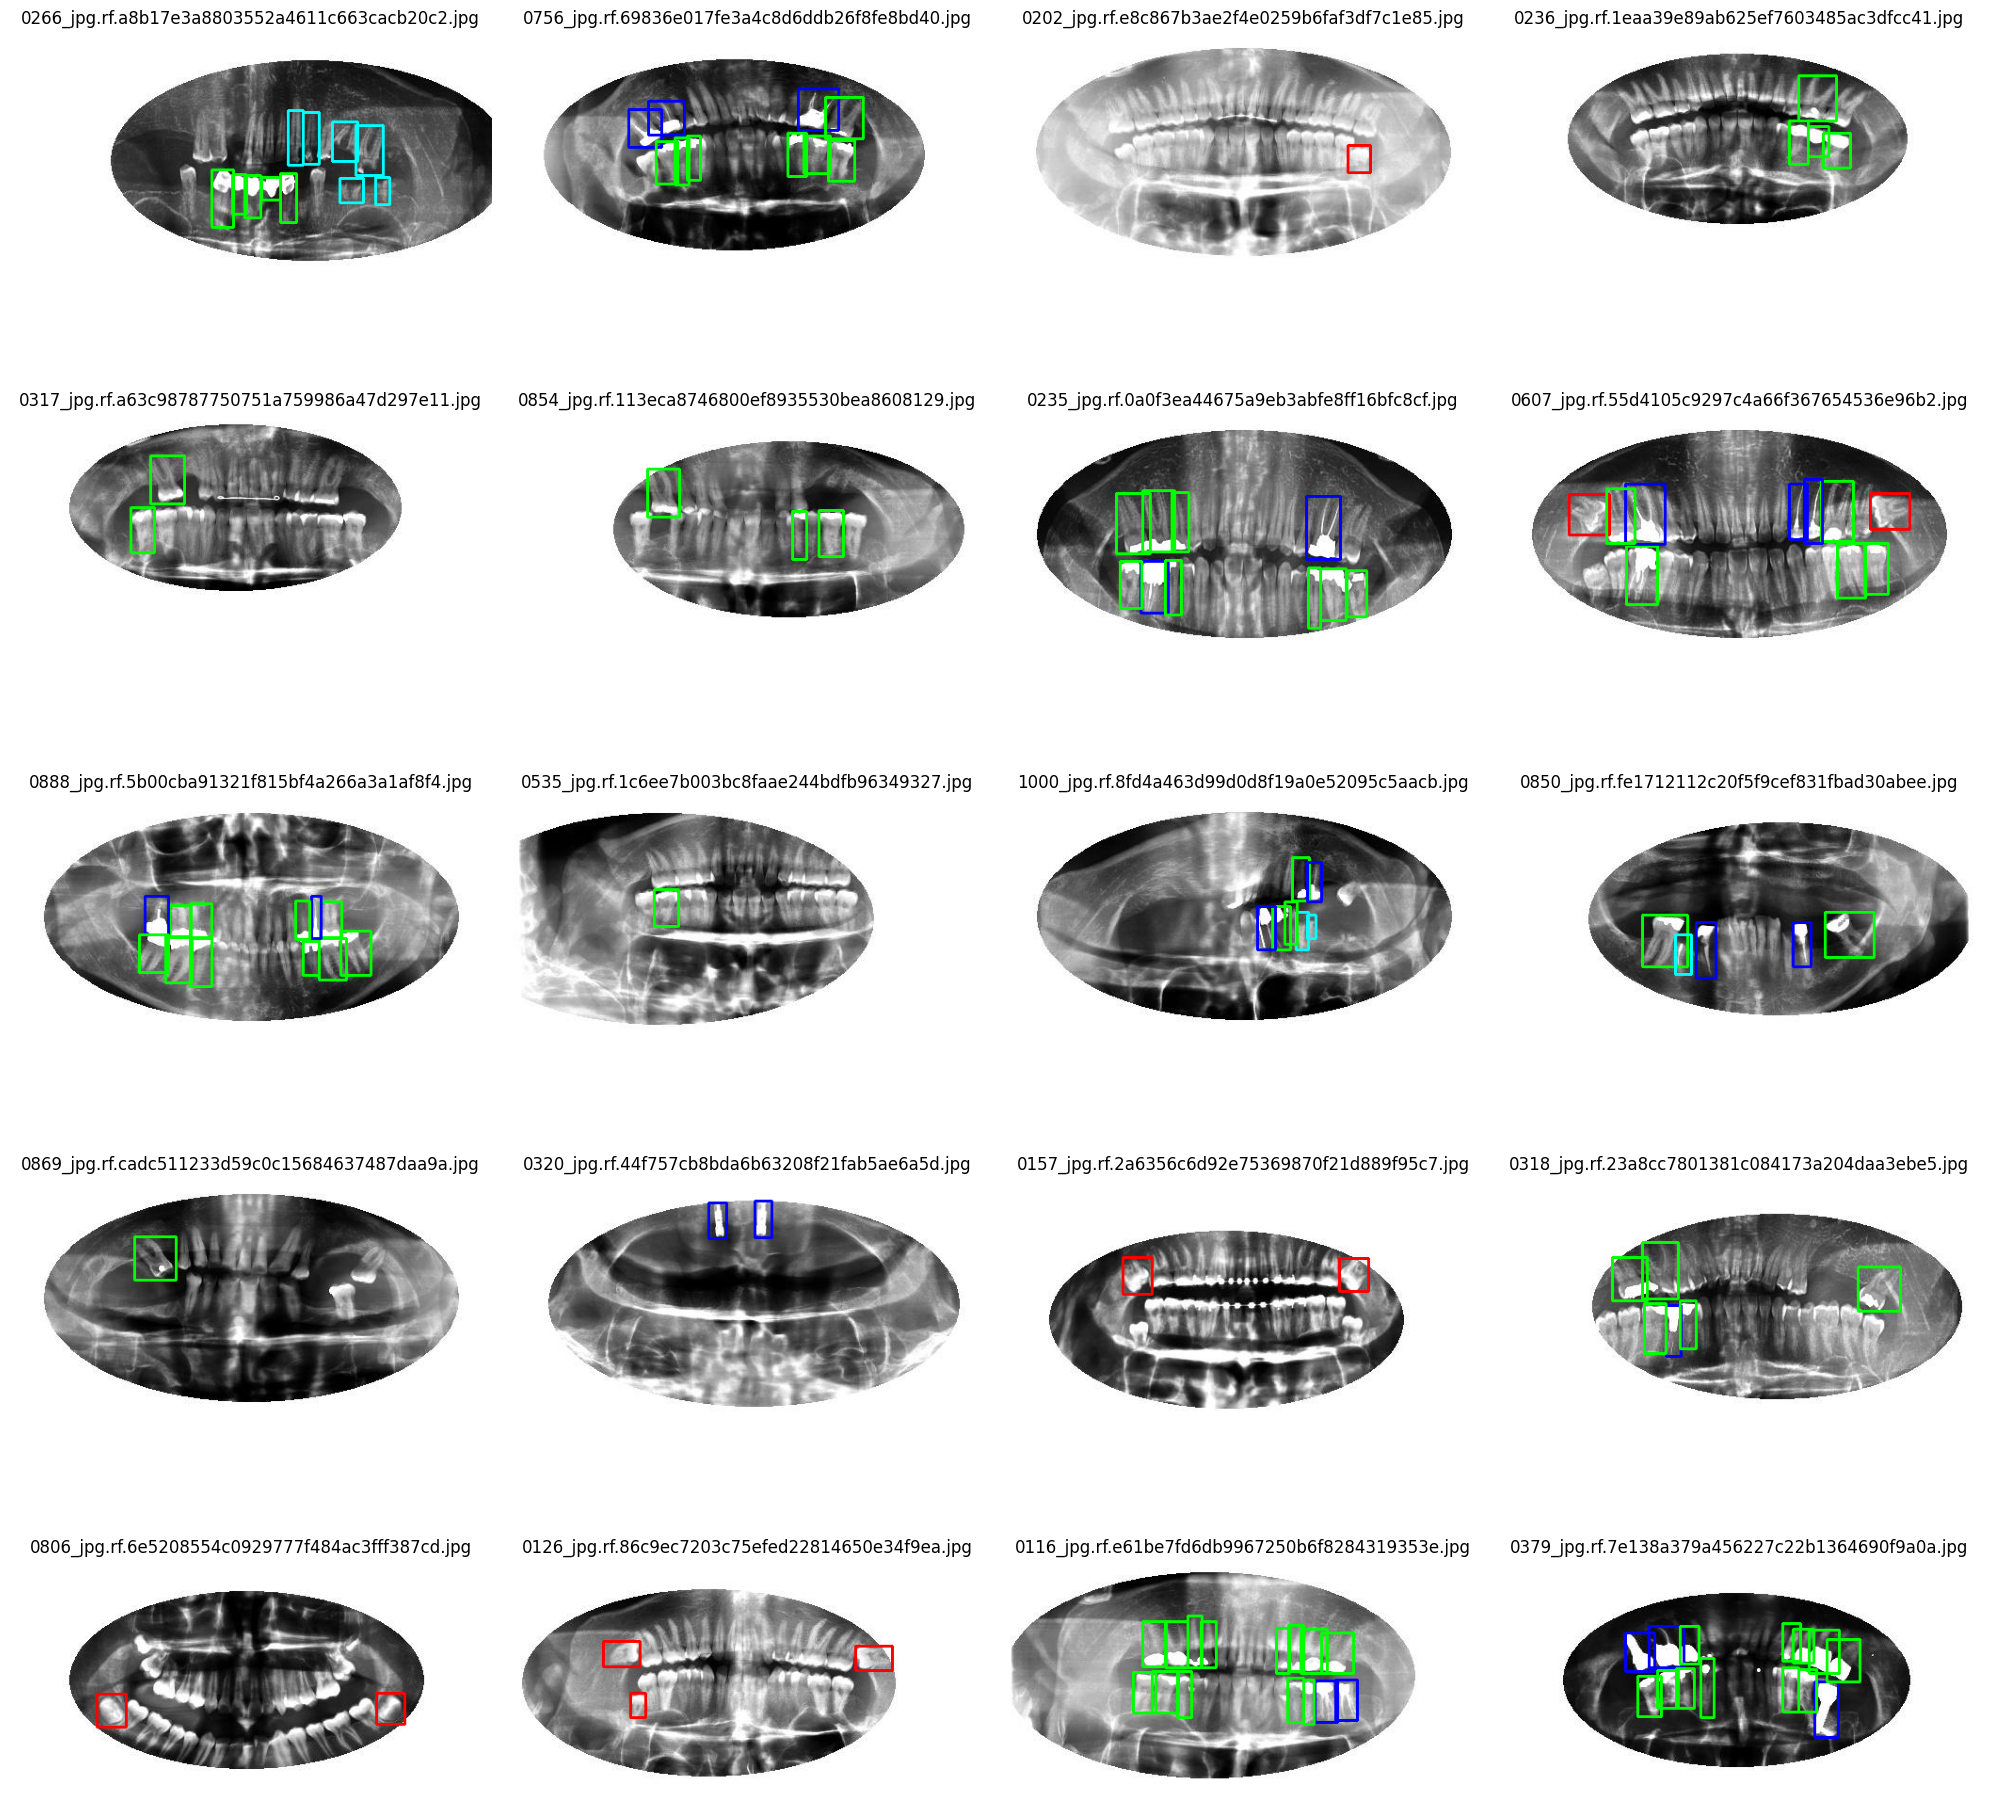

In [3]:
# Define the path to the 'train' folder and the CSV file
train_folder = "/kaggle/input/dental-radiography/train"
csv_file = "/kaggle/input/dental-radiography/train/_annotations.csv"

# Read the CSV file
annotations = pd.read_csv(csv_file)

# Get a list of unique image filenames
unique_images = annotations['filename'].unique()

# Randomly select 20 unique images
random_images = random.sample(list(unique_images), 20)

# Define a color map for the classes
class_colors = {
    'Implant': (255, 0, 0),          # Red
    'Fillings': (0, 255, 0),         # Green
    'Impacted Tooth': (0, 0, 255),   # Blue
    'Cavity': (255, 255, 0),         # Cyan
}

# Create a figure to display the images using plt.subplot
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

# Iterate over the randomly selected images and highlight the bounding boxes
for ax, img_name in zip(axes, random_images):
    # Load the image
    img_path = os.path.join(train_folder, img_name)
    image = cv2.imread(img_path)

    # Get the bounding boxes and classes for the current image
    img_annotations = annotations[annotations['filename'] == img_name]

    # Draw the bounding boxes
    for _, row in img_annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        label = row['class']
        color = class_colors.get(label, (255, 255, 255))  # Default to white if class not found
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

    # Convert BGR image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    ax.imshow(image_rgb)
    ax.axis('off')
    ax.set_title(img_name)

plt.tight_layout()
plt.show()

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Preprocessing</h1>  
     
</div>

Before applying segmentation, the images undergo a preprocessing step to enhance their quality. The preprocessing involves selecting the green channel of the image, dilating the mask, thresholding, and applying CLAHE (Contrast Limited Adaptive Histogram Equalization).

In [3]:
def preprocess_images(main_path, target_path):
    folders = ['train', 'valid', 'test']

    for folder in folders:
        input_folder_path = os.path.join(main_path, folder)
        output_folder_path = os.path.join(target_path, folder)

        # Create the target folder if it doesn't exist
        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)

        for filename in os.listdir(input_folder_path):
            if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
                img_path = os.path.join(input_folder_path, filename)
                img = cv2.imread(img_path)[:, :, 1]  # Read the image and select the second channel
                img2 = img - 255
                kernel = np.ones((2, 2), np.uint8)
                kernel2 = np.ones((3, 3), np.uint8)
                
                dilated_mask = cv2.dilate(img2, kernel, iterations=3)
                ret, thresh = cv2.threshold(dilated_mask, 0, 255, cv2.THRESH_BINARY)
                dilated_mask2 = cv2.dilate(thresh, kernel2, iterations=3)
                img = img / 255.0
                res_img = dilated_mask2 * img
                
                res_img = np.uint8(res_img)
                clahe_op = cv2.createCLAHE(clipLimit=20)
                final_img = clahe_op.apply(res_img)
                
                output_img_path = os.path.join(output_folder_path, filename)
                cv2.imwrite(output_img_path, final_img)  # Save the processed image to the target path


In [4]:
# Specify the main directory containing 'train', 'valid', and 'test' folders
main_directory = '/kaggle/input/dental-radiography'
target_directory = '/kaggle/working'

preprocess_images(main_directory, target_directory)

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Segmentation</h1>  
     
</div>

The segmentation step leverages the **Segment Anything Model (SAM)** to isolate and extract individual teeth from the radiographs. This section includes functions to load images and annotations, segment injured teeth, save segmented parts, segment normal teeth, black out injured areas, and remove images below a certain pixel threshold.

1. `def load_image_and_annotations(image_path, annotation_csv)`: Load an image and its corresponding annotations from a CSV file.


2.	`def segment_injured_tooth(image, bbox, predictor)`: Segment an injured tooth based on the bounding box using the SAM predictor.


3.	`def save_segmented_part(image, mask, label, output_folder, part_index, filename)`: Save the segmented part of the image using the provided mask.


4.	`def segment_normal_teeth(image, annotations, mask_generator, normal_folder, filename)`: Segment normal teeth in the image by generating masks that do not overlap with injured areas.


5.	`def black_out_injured_areas(image, annotations)`: Black out areas of the image corresponding to injured teeth based on annotations.


6.	`def remove_images_below_threshold(folder_path, threshold)`: Remove images from the folder if the percentage of non-zero pixels is below the threshold.


7.	`def process_folder(folder_path, annotation_csv, predictor, mask_generator, base_path)`: Process a folder of images by segmenting injured and normal teeth, and saving the results.

In [5]:
def load_image_and_annotations(image_path, annotation_csv):
    # Load the image
    image = cv2.imread(image_path)
    # Read the annotation CSV
    annotations = pd.read_csv(annotation_csv)
    # Filter annotations for the given image
    annotations = annotations[annotations['filename'] == os.path.basename(image_path)]
    return image, annotations

In [6]:
def segment_injured_tooth(image, bbox, predictor):
    # Set the image for the predictor
    predictor.set_image(image)
    # Prepare the input box for the segment-anything tool
    input_box = np.array(bbox)
    # Perform segmentation
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False
    )
    return masks, scores

In [7]:
def save_segmented_part(image, mask, label, output_folder, part_index, filename):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Extract the segmented part using the mask
    segmented_part = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
    # Define the output path with the original filename and part index
    output_path = os.path.join(output_folder, f'{filename}_segment_{part_index}.png')
    # Save the segmented part
    cv2.imwrite(output_path, segmented_part)
    # print(f'Segmented part saved to {output_path}')

In [8]:
def segment_normal_teeth(image, annotations, mask_generator, normal_folder, filename):
    # Generate masks for the whole image
    masks = mask_generator.generate(image)
    if not os.path.exists(normal_folder):
        os.makedirs(normal_folder)
    # Save each mask that doesn't overlap with any bbox and isn't all black
    h, w, _ = image.shape
    for i, mask in enumerate(masks):
        if np.count_nonzero(mask['segmentation']) < 0.1 * h * w:  # Skip if the mask covers more than 10% of the entire image
            segmented_part = cv2.bitwise_and(image, image, mask=mask['segmentation'].astype(np.uint8))
            if not np.all(segmented_part == 0):  # Check if the segmented part is not all black
                output_path = os.path.join(normal_folder, f'{filename}_segment_{i}.png')
                cv2.imwrite(output_path, segmented_part)
                # print(f'Normal part saved to {output_path}')

In [9]:
def black_out_injured_areas(image, annotations):
    # Create a mask with the same dimensions as the image, initialized to zeros
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    # Fill the regions corresponding to the injured areas with 255
    for index, row in annotations.iterrows():
        cv2.rectangle(mask, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), 255, -1)
    # Black out the injured areas in the image
    blacked_out_image = image.copy()
    blacked_out_image[mask == 255] = 0
    return blacked_out_image

In [10]:
def remove_images_below_threshold(folder_path, threshold):
    """
    Remove images that have a percentage of non-zero pixels below the given threshold.
    """
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Could not read image: {file_path}")
            continue
        total_pixels = image.size
        non_zero_pixels = np.count_nonzero(image)
        percent_non_zero = (non_zero_pixels / total_pixels) * 100
        if percent_non_zero < threshold:
            os.remove(file_path)
            # print(f"Removed image below threshold: {file_path} ({percent_non_zero:.2f}% non-zero pixels)")

In [11]:
def process_folder(folder_path, annotation_csv, predictor, mask_generator, base_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    for image_file in tqdm(image_files, desc=f'Processing {folder_path}'):
        image_path = os.path.join(folder_path, image_file)
        image, annotations = load_image_and_annotations(image_path, annotation_csv)
        # Process each annotation
        for index, row in annotations.iterrows():
            bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
            label = row['class']
            # Segment the injured tooth
            masks, scores = segment_injured_tooth(image, bbox, predictor)
            # Save the segmented part of the first mask with a unique name
            save_segmented_part(image, masks[0], label, os.path.join(base_path, folder_path, label), index, os.path.splitext(image_file)[0])
        # Black out the injured areas in the image
        blacked_out_image = black_out_injured_areas(image, annotations)
        # Segment and save normal teeth
        segment_normal_teeth(blacked_out_image, annotations, mask_generator, os.path.join(base_path, folder_path, 'Normal'), os.path.splitext(image_file)[0])
        # Remove images below the threshold
        remove_images_below_threshold(os.path.join(base_path, folder_path, 'Normal'), threshold=0.21)

In [12]:
# Initialize the segment-anything model and mask generator
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam.to(device=device)
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Post-Processing</h1>  
     
</div>

After segmentation, the original images are removed, and the segmented images are cropped and resized to a standard size. The processed images are then zipped for easier distribution and storage.

In [13]:
def remove_original_images(base_path, folders):
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) and not filename.endswith(('.csv', '.zip')):  # Ensure not to remove other files
                os.remove(file_path)
                # print(f'Removed original image: {file_path}')

In [14]:
def crop_and_resize_image(image_path, output_size=(64, 64)):
    # Open an image file
    with Image.open(image_path) as img:
        # Convert image to numpy array
        img_array = np.array(img)
        
        # Find non-zero pixels
        non_zero_indices = np.argwhere(img_array)
        
        # Get the bounding box of non-zero pixels
        top_left = non_zero_indices.min(axis=0)
        bottom_right = non_zero_indices.max(axis=0)
        
        # Crop the image to the bounding box
        cropped_img = img_array[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
        
        # Convert cropped image back to PIL Image
        cropped_img_pil = Image.fromarray(cropped_img)
        
        # Resize the image
        resized_img = cropped_img_pil.resize(output_size)
        
        # Save the resized image, overwriting the original
        resized_img.save(image_path)

def process_images_in_directory(root_directory):
    # Walk through the root directory
    for subdir, _, files in os.walk(root_directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_path = os.path.join(subdir, file)
                crop_and_resize_image(image_path)
                # print(f"Processed: {image_path}")

In [15]:
def zip_folder(folder_path):
    zip_file_path = f"{folder_path}.zip"
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=os.path.dirname(folder_path))
                zipf.write(file_path, arcname)
    print(f'Zipped folder: {zip_file_path}')

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Providing Valid data</h1>  
     
</div>

In [16]:
# Process valid folder
folders = ['valid']
base_path = '/kaggle/working'
annotation_files = {'valid': '/kaggle/input/dental-radiography/valid/_annotations.csv'}


# Process valid folder
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    annotation_csv = annotation_files[folder]
    process_folder(folder_path, annotation_csv, predictor, mask_generator, base_path)

Processing /kaggle/working/valid: 100%|██████████| 121/121 [46:21<00:00, 22.98s/it]


In [18]:
# Define the paths to the folders
base_path = '/kaggle/working'
folders = ['valid']

# Remove original images
remove_original_images(base_path, folders)

In [20]:
# Specify the root directory containing subdirectories with images
root_directory = '/kaggle/working/valid'

# Process the images
process_images_in_directory(root_directory)

In [23]:
base_path = '/kaggle/working'
folders = ['valid']

# Zip valid folder
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    zip_folder(folder_path)

Zipped folder: /kaggle/working/valid.zip


<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Providing Test data</h1>  
     
</div>

In [24]:
# Process valid folder
folders = ['test']
base_path = '/kaggle/working'
annotation_files = {'test': '/kaggle/input/dental-radiography/test/_annotations.csv'}


# Process each folder
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    annotation_csv = annotation_files[folder]
    process_folder(folder_path, annotation_csv, predictor, mask_generator, base_path)

Processing /kaggle/working/test: 100%|██████████| 73/73 [27:18<00:00, 22.45s/it]


In [ ]:
# Define the paths to the folders
base_path = '/kaggle/working'
folders = ['test']

# Remove original images
remove_original_images(base_path, folders)

In [29]:
# Specify the root directory containing subdirectories with images
root_directory = '/kaggle/working/test'

# Process the images
process_images_in_directory(root_directory)

In [30]:
base_path = '/kaggle/working'
folders = ['test']

# Zip the folders
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    zip_folder(folder_path)

Zipped folder: /kaggle/working/test.zip


<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Providing Train data</h1>  
     
</div>

In [16]:
# Process valid folder
folders = ['train']
base_path = '/kaggle/working'
annotation_files = {'train': '/kaggle/input/dental-radiography/train/_annotations.csv'}


# Process each folder
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    annotation_csv = annotation_files[folder]
    process_folder(folder_path, annotation_csv, predictor, mask_generator, base_path)

Processing /kaggle/working/train: 100%|██████████| 1075/1075 [10:40:26<00:00, 35.75s/it] 


In [17]:
# Define the paths to the folders
base_path = '/kaggle/working'
folders = ['train']

# Remove original images
remove_original_images(base_path, folders)

In [18]:
# Specify the root directory containing subdirectories with images
root_directory = '/kaggle/working/train'

# Process the images
process_images_in_directory(root_directory)

In [19]:
base_path = '/kaggle/working'
folders = ['train']

# Zip the folders
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    zip_folder(folder_path)

Zipped folder: /kaggle/working/train.zip
